*PARTE II*

A continuación se realizan un modelo MLP. Buscando llegar al mejor resultado se realizaron varios modelos modificando cada vez las distintas variables. Para esto utilizamos la herramienta Weights & Biases (WandB).

WandB es una herramienta que permite registrar ordenadamente los experimentos en una tabla a través de los parámetros que se le pasen a wandb.config. Esto a su vez permite visualizar algunas curvas por defecto y aquellas que nosotros decidamos conformar y pasar a través del log.

Para cada configuración realizada se incluyen la cantidad de capas, la cantidad de neuronas por capa, batch size y learning rate utilzados.
Y WandB nos permite analizar las curvas de Accuracy y Loss entre otras.
Tambien para cada configuración se realizo el score F1, la matriz de confusión y la curva ROC.

En el siguiente link se puede visualizar nuestro workspace que de manera interactiva nos permite comparar todos las configuraciones realizadas:

https://wandb.ai/cerrato-dip-fontecha/TP1/table?workspace=user-

A continuación se muestran los mejores resultados para cada uno de los modelos para el caso de sin procesamiento y con los dos tipos de procesamiento antes mencionados. La técnica de validación utilizada fue la de holdout

#Librerias

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from string import punctuation
from termcolor import colored
from collections import Counter
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.model_selection import train_test_split
import pickle

import wandb
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback

In [ ]:
!pip install wandb -qqq
!pip install scikit-plot -qqq
!pip install nltk

In [ ]:
wandb.login()

wandb: Currently logged in as: fdip (use `wandb login --relogin` to force relogin)


True

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
#Fede
%cd /content/drive/My Drive/RN
!ls

/content/drive/My Drive/RN
lem_test.pck   stem_stop_test.pck   test_data.hdf5   wandb
lem_train.pck  stem_stop_train.pck  train_data.hdf5
lem_val.pck    stem_stop_val.pck    valid_data.hdf5


# Modelos sin preprocesamiento

In [ ]:
df_train = pd.read_hdf("train_data.hdf5")
df_valid = pd.read_hdf("valid_data.hdf5")
df_test = pd.read_hdf("test_data.hdf5")

df_test.reset_index(drop=True, inplace = True)
df = pd.concat([df_train, df_valid], ignore_index = True) #unimos train y valid para re-dividir.
df.head()

xx_train, xx_val, y_train, y_valid = train_test_split(df['text'], df['gold_label'], test_size=0.2, random_state=42)

y_train.loc[y_train == "entailment"] = 0
y_train.loc[y_train == "neutral"] = 1
y_train.loc[y_train == "contradiction"] = 2

y_valid.loc[y_valid == "entailment"] = 0
y_valid.loc[y_valid == "neutral"] = 1
y_valid.loc[y_valid == "contradiction"] = 2

In [ ]:
text_train = df_train["text"].tolist()
y_train = df_train["gold_label"].tolist()

text_valid = df_valid["text"].tolist()
y_valid = df_valid["gold_label"].tolist()

x_test = df_test["text"].tolist()

In [ ]:
cv = CountVectorizer(min_df=100, max_df = 0.8, ngram_range = (1,1))
x_train = cv.fit_transform(text_train)
x_valid = cv.transform(text_valid)

In [ ]:
ohe = OneHotEncoder()
ohe.fit(np.array(y_train).reshape(-1,1))
y_train_enc = ohe.transform(np.array(y_train).reshape(-1,1))
y_valid_enc = ohe.transform(np.array(y_valid).reshape(-1,1))

In [ ]:
x_train = x_train.toarray()
x_valid = x_valid.toarray()
y_train_enc = y_train_enc.toarray()
y_valid_enc = y_valid_enc.toarray()

##Model

In [ ]:

# Set an experiment name to group training and evaluation
experiment_name = wandb.util.generate_id()

# Start a run, tracking hyperparameters
wandb.init(entity="cerrato-dip-fontecha",
  project="TP1",
  group=experiment_name,
  config={
    "layer_1": 5,
    "activation_1": "relu",
    "shape": x_train.shape[1],
    "layer_2": 10,
    "activation_2": "relu",
    "layer_3": 3,
    "activation_3": "softmax",
    "optimizer": "sgd",
    "learning_rate": 0.1,
    "loss": 'categorical_crossentropy',
    "metric": "accuracy",
    "epoch": 20,
    "batch_size": 100
  })
config = wandb.config


# Build a model
model = Sequential()
model.add(Dense(config.layer_1, input_shape = (config.shape,), activation=config.activation_1))
model.add(Dense(config.layer_2, activation=config.activation_2))
model.add(Dense(config.layer_3, activation=config.activation_3))
model.summary()
#selectedOptimizer = SGD(lr=lr)
selectedOptimizer = SGD(learning_rate=0.001)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model.compile(loss = config.loss, optimizer=selectedOptimizer, metrics=[config.metric])


history = model.fit(x = x_train,
                    y = y_train_enc,
                    batch_size = config.batch_size,
                    verbose=1,
                    epochs=config.epoch, 
                    validation_data = (x_valid, y_valid_enc),
                    callbacks=[WandbCallback()])


# Add in a Jupyter notebook to indicate the run has finished
wandb.finish()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 10950     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 11,043
Trainable params: 11,043
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
5494/5494 [==============================] - 16s 3ms/step - loss: 1.0960 - accuracy: 0.3735 - val_loss: 1.0938 - val_accuracy: 0.3880
Epoch 2/20
5494/5494 [==============================] - 15s 3ms/step - loss: 1.0909 - accuracy: 0.4116 - val_loss: 1.0871 - val_accuracy: 0.4259
Epoch 3/20
5494/5494 [==============================] - 15s 3ms/step - loss: 1.0828 - accura

accuracy,▁▂▃▄▄▄▅▅▆▆▆▇▇▇▇▇████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,███▇▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁
val_accuracy,▁▂▃▄▄▄▅▅▆▆▆▇▇▇▇█████
val_loss,██▇▇▆▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁
accuracy,0.58295
best_epoch,19
best_val_loss,0.89946
epoch,19
loss,0.90711
val_accuracy,0.58616


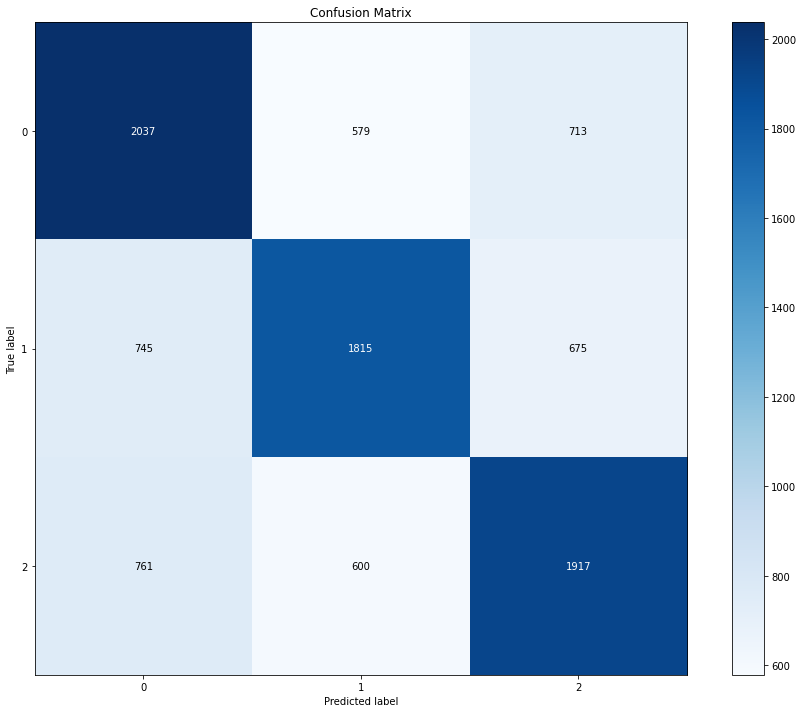

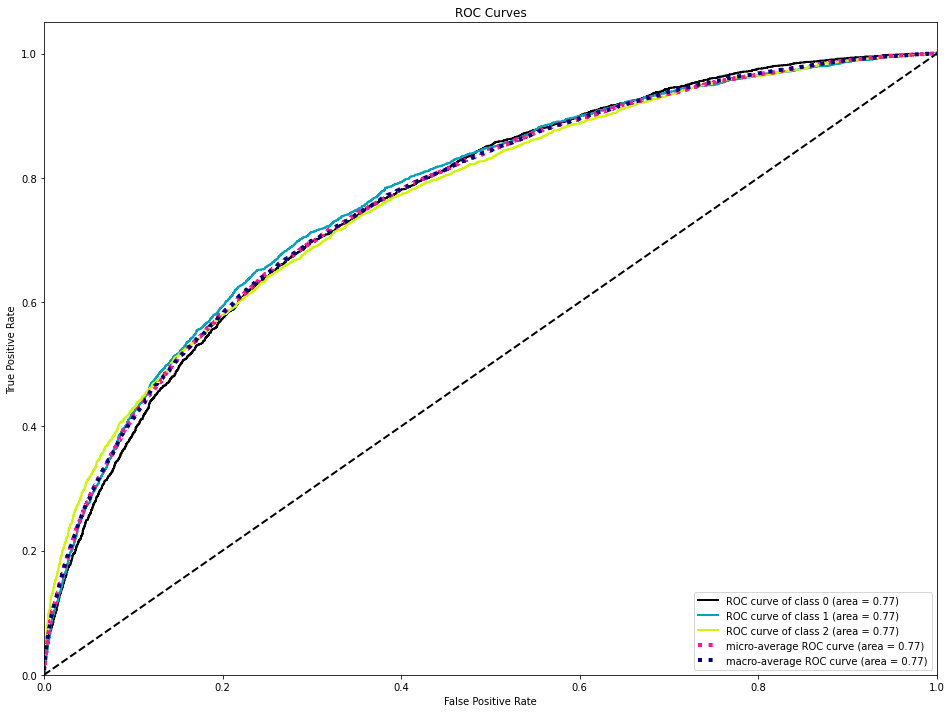

In [ ]:
wandb.init(entity="cerrato-dip-fontecha", project="TP1", group=experiment_name)
#wandb.init(project="TP1", group=experiment_name)

# Log F1 Score
y_test_pred = np.asarray(model.predict(x_valid))
y_test_pred_class = np.argmax(y_test_pred, axis=1)
f1 = f1_score(y_valid, y_test_pred_class, average='micro')
wandb.log({"f1": f1})

# Log Confusion Matrix
fig, ax = plt.subplots(figsize=(16, 12))
plot_confusion_matrix(y_valid, y_test_pred_class, ax=ax)
wandb.log({"confusion_matrix": wandb.Image(fig)})

# Log ROC Curve
fig, ax = plt.subplots(figsize=(16, 12))
plot_roc(y_valid, y_test_pred, ax=ax)
wandb.log({"plot_roc": wandb.Image(fig)})

class_score_data = []
for test, pred in zip(y_valid, y_test_pred):
  class_score_data.append([test, pred])
class_scores_table = wandb.Table(data=class_score_data, columns=["test", "pred"])
wandb.log({"class_scores": class_scores_table})

#Modelo con preprocesado LEM

In [ ]:
df_train = pd.read_hdf("train_data.hdf5")
df_valid = pd.read_hdf("valid_data.hdf5")
df_test = pd.read_hdf("test_data.hdf5")

df_test.reset_index(drop=True, inplace = True)
df = pd.concat([df_train, df_valid], ignore_index = True) #unimos train y valid para re-dividir.
df.head()

xx_train, xx_val, y_train, y_valid = train_test_split(df['text'], df['gold_label'], test_size=0.2, random_state=42)

y_train.loc[y_train == "entailment"] = 0
y_train.loc[y_train == "neutral"] = 1
y_train.loc[y_train == "contradiction"] = 2

y_valid.loc[y_valid == "entailment"] = 0
y_valid.loc[y_valid == "neutral"] = 1
y_valid.loc[y_valid == "contradiction"] = 2

In [ ]:
with open ('lem_train.pck', 'rb') as fp:
    lem_train = pickle.load(fp)

with open ('lem_val.pck', 'rb') as fp:
    lem_val = pickle.load(fp)

with open ('lem_test.pck', 'rb') as fp:
    lem_test = pickle.load(fp)

In [ ]:
y_train = y_train.tolist()
y_valid = y_valid.tolist()
x_test = df_test["text"].tolist()

In [ ]:
cv = CountVectorizer(min_df=100, max_df = 0.8, ngram_range = (1,1))
x_train = cv.fit_transform(lem_train)
x_valid = cv.transform(lem_val)

In [ ]:
ohe = OneHotEncoder()
ohe.fit(np.array(y_train).reshape(-1,1))
y_train_enc = ohe.transform(np.array(y_train).reshape(-1,1))
y_valid_enc = ohe.transform(np.array(y_valid).reshape(-1,1))

In [ ]:
x_train = x_train.toarray()
x_valid = x_valid.toarray()
y_train_enc = y_train_enc.toarray()
y_valid_enc = y_valid_enc.toarray()

##Model

In [ ]:

# Set an experiment name to group training and evaluation
experiment_name = wandb.util.generate_id()

# Start a run, tracking hyperparameters
wandb.init(entity="cerrato-dip-fontecha",
  project="TP1",
  group=experiment_name,
  config={
    "layer_1": 10,
    "activation_1": "relu",
    "shape": x_train.shape[1],
    "layer_2": 10,
    "activation_2": "relu",
    "layer_3": 3,
    "activation_3": "softmax",
    "optimizer": "sgd",
    "learning_rate": 0.1,
    "loss": 'categorical_crossentropy',
    "metric": "accuracy",
    "epoch": 20,
    "batch_size": 50
  })
config = wandb.config


# Build a model
model = Sequential()
model.add(Dense(config.layer_1, input_shape = (config.shape,), activation=config.activation_1))
model.add(Dense(config.layer_2, activation=config.activation_2))
model.add(Dense(config.layer_3, activation=config.activation_3))
model.summary()
#selectedOptimizer = SGD(lr=lr)
selectedOptimizer = SGD(config.learning_rate)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model.compile(loss = config.loss, optimizer=selectedOptimizer, metrics=[config.metric])


history = model.fit(x = x_train,
                    y = y_train_enc,
                    batch_size = config.batch_size,
                    verbose=1,
                    epochs=config.epoch, 
                    validation_data = (x_valid, y_valid_enc),
                    callbacks=[WandbCallback()])


# Add in a Jupyter notebook to indicate the run has finished
wandb.finish()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                16190     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 16,333
Trainable params: 16,333
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
8948/8948 [==============================] - 22s 2ms/step - loss: 0.8949 - accuracy: 0.5849 - val_loss: 0.8662 - val_accuracy: 0.6039
Epoch 2/20
8948/8948 [==============================] - 19s 2ms/step - loss: 0.8519 - accuracy: 0.6140 - val_loss: 0.8406 - val_accuracy: 0.6232
Epoch 3/20
8948/8948 [==============================] - 19s 2ms/step - loss: 0.8398 - accura

accuracy,▁▅▆▆▆▇▇▇▇▇▇▇████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▆▄▆▆▆▇▆█▇▆▆▆▇█▅█▇▆█
val_loss,█▄▅▃▃▃▂▃▁▁▃▃▃▁▁▄▁▂▃▁
accuracy,0.64168
best_epoch,19
best_val_loss,0.82369
epoch,19
loss,0.80539
val_accuracy,0.63155


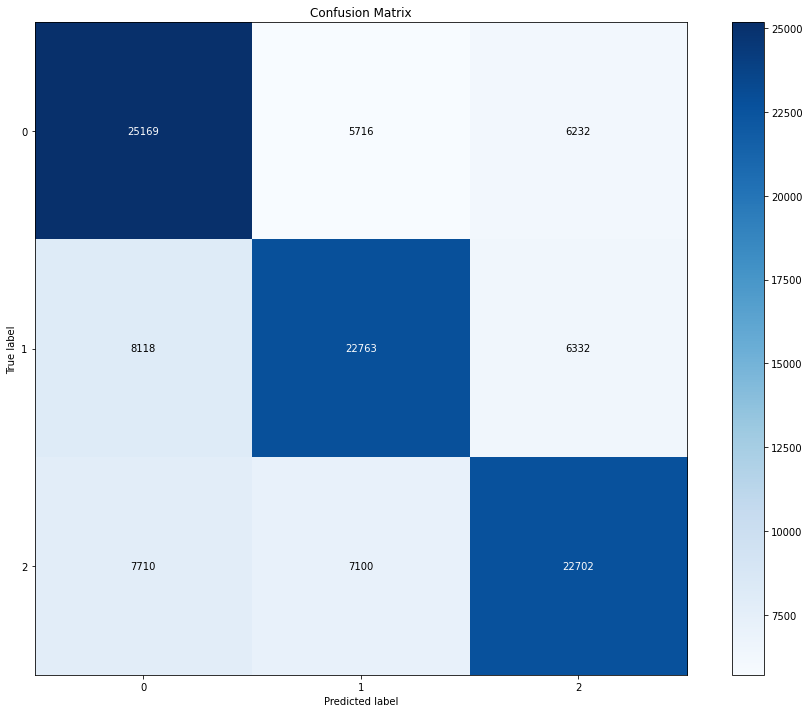

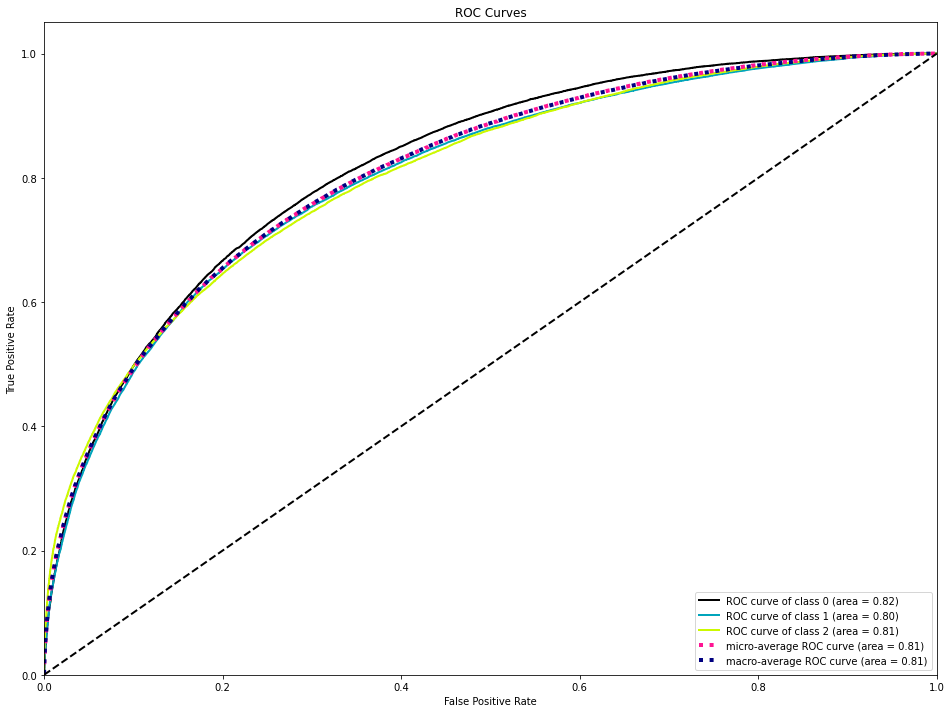

In [ ]:
wandb.init(entity="cerrato-dip-fontecha", project="TP1", group=experiment_name)
#wandb.init(project="TP1", group=experiment_name)

# Log F1 Score
y_test_pred = np.asarray(model.predict(x_valid))
y_test_pred_class = np.argmax(y_test_pred, axis=1)
f1 = f1_score(y_valid, y_test_pred_class, average='micro')
wandb.log({"f1": f1})

# Log Confusion Matrix
fig, ax = plt.subplots(figsize=(16, 12))
plot_confusion_matrix(y_valid, y_test_pred_class, ax=ax)
wandb.log({"confusion_matrix": wandb.Image(fig)})

# Log ROC Curve
fig, ax = plt.subplots(figsize=(16, 12))
plot_roc(y_valid, y_test_pred, ax=ax)
wandb.log({"plot_roc": wandb.Image(fig)})

class_score_data = []
for test, pred in zip(y_valid, y_test_pred):
  class_score_data.append([test, pred])
class_scores_table = wandb.Table(data=class_score_data, columns=["test", "pred"])
wandb.log({"class_scores": class_scores_table})

#Modelo con preprocesado LEM+Stemmer+Stopwords+puntuacion

In [ ]:
df_train = pd.read_hdf("train_data.hdf5")
df_valid = pd.read_hdf("valid_data.hdf5")
df_test = pd.read_hdf("test_data.hdf5")

df_test.reset_index(drop=True, inplace = True)
df = pd.concat([df_train, df_valid], ignore_index = True) #unimos train y valid para re-dividir.
df.head()

xx_train, xx_val, y_train, y_valid = train_test_split(df['text'], df['gold_label'], test_size=0.2, random_state=42)

y_train.loc[y_train == "entailment"] = 0
y_train.loc[y_train == "neutral"] = 1
y_train.loc[y_train == "contradiction"] = 2

y_valid.loc[y_valid == "entailment"] = 0
y_valid.loc[y_valid == "neutral"] = 1
y_valid.loc[y_valid == "contradiction"] = 2

In [ ]:
with open ('stem_stop_train.pck', 'rb') as fp:
    stem_stop_train = pickle.load(fp)

with open ('stem_stop_val.pck', 'rb') as fp:
    stem_stop_val = pickle.load(fp)

with open ('stem_stop_test.pck', 'rb') as fp:
    stem_stop_test = pickle.load(fp)

In [ ]:
y_train = y_train.tolist()
y_valid = y_valid.tolist()
x_test = df_test["text"].tolist()

In [ ]:
cv = CountVectorizer(min_df=100, max_df = 0.8, ngram_range = (1,1))
x_train = cv.fit_transform(stem_stop_train)
x_valid = cv.transform(stem_stop_val)

In [ ]:
ohe = OneHotEncoder()
ohe.fit(np.array(y_train).reshape(-1,1))
y_train_enc = ohe.transform(np.array(y_train).reshape(-1,1))
y_valid_enc = ohe.transform(np.array(y_valid).reshape(-1,1))

In [ ]:
x_train = x_train.toarray()
x_valid = x_valid.toarray()
y_train_enc = y_train_enc.toarray()
y_valid_enc = y_valid_enc.toarray()

##Model

In [ ]:

# Set an experiment name to group training and evaluation
experiment_name = wandb.util.generate_id()

# Start a run, tracking hyperparameters
wandb.init(entity="cerrato-dip-fontecha",
  project="TP1",
  group=experiment_name,
  config={
    "layer_1": 10,
    "activation_1": "relu",
    "shape": x_train.shape[1],
    "layer_2": 10,
    "activation_2": "relu",
    "layer_3": 3,
    "activation_3": "softmax",
    "optimizer": "sgd",
    "learning_rate": 0.1,
    "loss": 'categorical_crossentropy',
    "metric": "accuracy",
    "epoch": 20,
    "batch_size": 50
  })
config = wandb.config


# Build a model
model = Sequential()
model.add(Dense(config.layer_1, input_shape = (config.shape,), activation=config.activation_1))
model.add(Dense(config.layer_2, activation=config.activation_2))
model.add(Dense(config.layer_3, activation=config.activation_3))
model.summary()
#selectedOptimizer = SGD(lr=lr)
selectedOptimizer = SGD(config.learning_rate)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model.compile(loss = config.loss, optimizer=selectedOptimizer, metrics=[config.metric])


history = model.fit(x = x_train,
                    y = y_train_enc,
                    batch_size = config.batch_size,
                    verbose=1,
                    epochs=config.epoch, 
                    validation_data = (x_valid, y_valid_enc),
                    callbacks=[WandbCallback()])


# Add in a Jupyter notebook to indicate the run has finished
wandb.finish()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                15360     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 15,503
Trainable params: 15,503
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
8948/8948 [==============================] - 21s 2ms/step - loss: 0.9203 - accuracy: 0.5641 - val_loss: 0.8876 - val_accuracy: 0.5872
Epoch 2/20
8948/8948 [==============================] - 23s 3ms/step - loss: 0.8793 - accuracy: 0.5925 - val_loss: 0.8759 - val_accuracy: 0.5961
Epoch 3/20
8948/8948 [==============================] - 23s 3ms/step - loss: 0.8696 - accura

accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇███████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▂▅▁▆▇▆▆▆▆█▆▇█▅█▇██▇█
val_loss,▇▅█▃▂▂▃▃▂▂▄▂▁▃▂▂▁▁▁▁
accuracy,0.61975
best_epoch,17
best_val_loss,0.85566
epoch,19
loss,0.83702
val_accuracy,0.60687


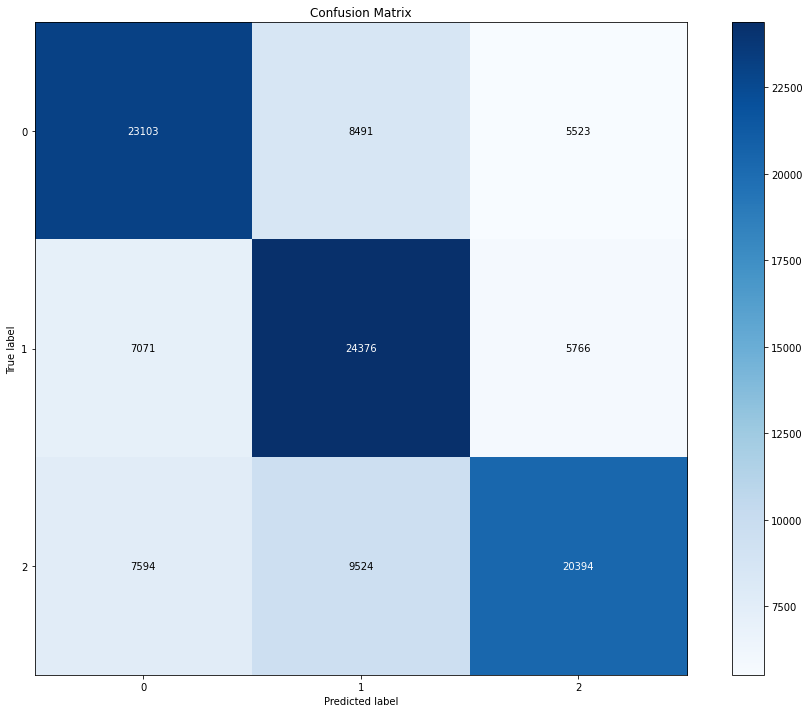

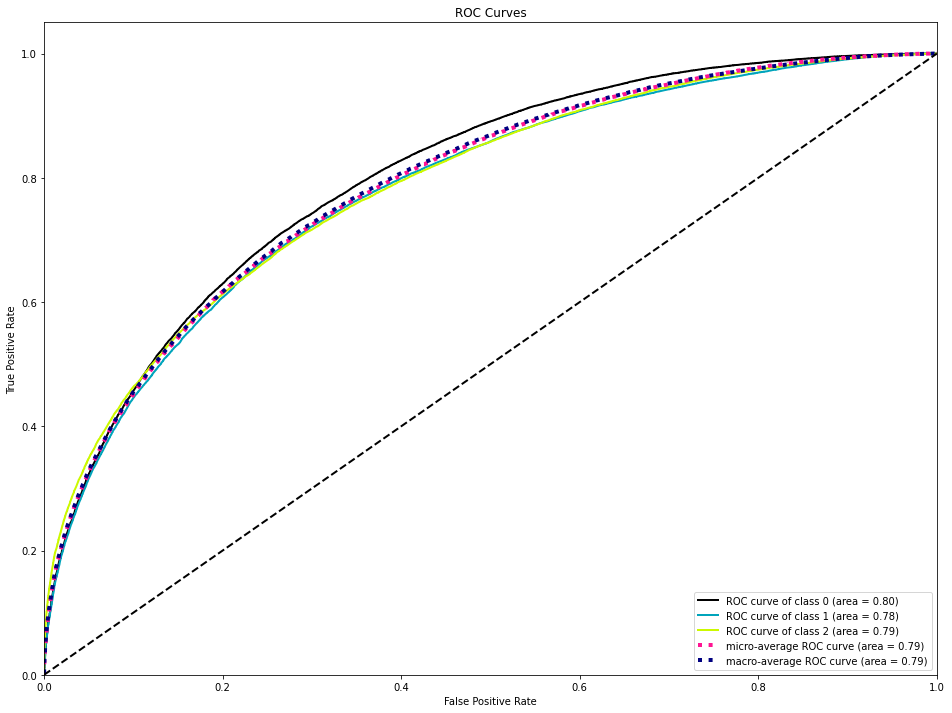

In [ ]:
wandb.init(entity="cerrato-dip-fontecha", project="TP1", group=experiment_name)
#wandb.init(project="TP1", group=experiment_name)

# Log F1 Score
y_test_pred = np.asarray(model.predict(x_valid))
y_test_pred_class = np.argmax(y_test_pred, axis=1)
f1 = f1_score(y_valid, y_test_pred_class, average='micro')
wandb.log({"f1": f1})

# Log Confusion Matrix
fig, ax = plt.subplots(figsize=(16, 12))
plot_confusion_matrix(y_valid, y_test_pred_class, ax=ax)
wandb.log({"confusion_matrix": wandb.Image(fig)})

# Log ROC Curve
fig, ax = plt.subplots(figsize=(16, 12))
plot_roc(y_valid, y_test_pred, ax=ax)
wandb.log({"plot_roc": wandb.Image(fig)})

class_score_data = []
for test, pred in zip(y_valid, y_test_pred):
  class_score_data.append([test, pred])
class_scores_table = wandb.Table(data=class_score_data, columns=["test", "pred"])
wandb.log({"class_scores": class_scores_table})

#Conclusiones
---

En primer lugar, podemos concluir que el dataset está sesgado ya que, teniendo en cuenta únicamente las hipótesis, logramos generar modelos capaces de predecir la clase correspondiente con una accuracy mayor al 60% en la mayoría de los casos. Dado que estos modelos ignoran cuál es la premisa correspondiente a cada hipótesis, un dataset no sesgado no debería ser capaz de alcanzar una accuracy mayor a la de un modelo que clasifique al azar, es decir, del 33% aproximadamente, es decir, la proporción de las tres clases en el dataset.

Por otro lado, tanto en Naive Bayes como en MLP el mejor modelo obtenido fue aquel en el que el preprocesamiento consistión únicamente de la lematización. Consideramos que esto tiene que ver con que un preprocesamiento más exhaustivo podría estar generando una pérdida de información, especialmente en la estructura de la hipóstesis. En el caso del preprocesamiento nulo, este obtuvo resultados que si bien menores, fueron muy similares a los de los modelos con lematización.

En cuanto a los hiperparámetros evaluados para Naive Bayes se encontró que en general el método de extracción de características por TfIdf arrojó mejores resultados que el de Count Vectorizer. A su vez, en todos los casos utilizar n-grams de 1 y 2 también resultó dar mejor score. Por último, el mejor alfa fue de 0.5.

El mejor modelo de MLP se obtuvo con tres capas, con diez neuronas en las primeras dos capas y tres en la capa de salida. La función de activación fue la 'relu' para las capas 1 y 2 y la 'softmax' para la capa 3. El batch_size utilizado fue de 50. Se logró un accuracy de 0.6420.

Finalmente, como comparación general entre ambos modelos, con MLP se obtuvo una accuracy mayor que con Naive Bayes, utilizando el mismo preprocesamiento.
